# Example 02

This example reproduces the results from Example 2 of from Quast & Wagner (2016)

The definition of the volume phase function and surface BRDF is as follows:

**Volume definition**

* optical depth ($\tau = 0.7$)
* single scattering albedo ($\omega = 0.3$)
* Volume phase function: HanyeyGreenstein function with 20 coefficients

**Surface definition**

* Cosine Lobe function with 10 coefficients

In [7]:
# imports
from rt1.rt1 import RT1 
from rt1.volume import HenyeyGreenstein   
from rt1.surface import CosineLobe 

import numpy as np
import pandas as pd

In [8]:
# definition of volume and surface
V = HenyeyGreenstein(tau=0.7, omega=0.3, t=0.7, ncoefs=20)
SRF = CosineLobe(ncoefs=10, i=5, NormBRDF=np.pi)

**Imaging geometry (backscattering case)**

In [9]:
# Specify imaging geometry
inc = np.arange(1.,89.,1.)  # specify incidence angle range [deg]
t_0 = np.deg2rad(inc)  # [rad]
# scattering angle; here the same as incidence angle, as backscatter
t_ex = t_0*1. 
# azimuth geometry angles
p_0 = np.ones_like(inc)*0. 
p_ex = np.ones_like(inc)*0. + np.pi  # 180 degree shift as backscatter

**Perform the simulations**

To perform the simulations, the RT model needs to estimate once coefficients. As these are the same for all imaging geometries, it makes sense to estimate these once and then transfer them to the subsequent calls, using the optional fn_input and _fnevals_input parameters.

In [10]:
# do actual calculations with specifies geometries
I0=1.  # set incident intensity
R = RT1(I0, t_0, t_ex, p_0, p_ex, V=V, SRF=SRF, geometry='mono')
res = pd.DataFrame(dict(zip(('tot','surf','vol','inter'), R.calc())), index=inc)

generation of _fnevals functions...
symengine
evaluating fn-coefficients...


**Plot results**

Plot both, the phase function and the BRDF. For more examples, see [examples.py](examples.py)

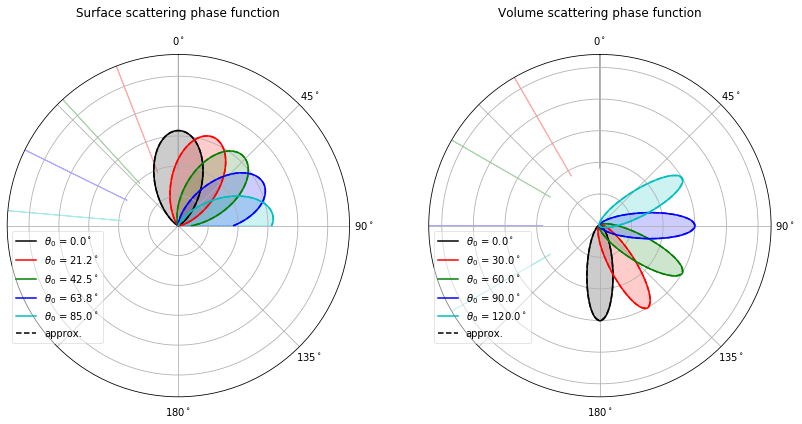

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25, 7))
ax1 = fig.add_subplot(111, projection='polar')
ax2 = fig.add_subplot(121, projection='polar')

# plot BRDF and phase function
plot1 = SRF.polarplot(inc = list(np.linspace(0,85,5)), multip = 1.5, legpos = (0.,0.5), polarax=ax2,
                     label='Surface scattering phase function', legend=True)
plot2 = V.polarplot(inc = list(np.linspace(0,120,5)) ,multip = 1.5, legpos = (0.0,0.5), polarax=ax1,
                     label='Volume scattering phase function', legend=True)

fig.tight_layout()
# plot only BRDF
#V.polarplot()
#plot only p
#SRF.polarplot()

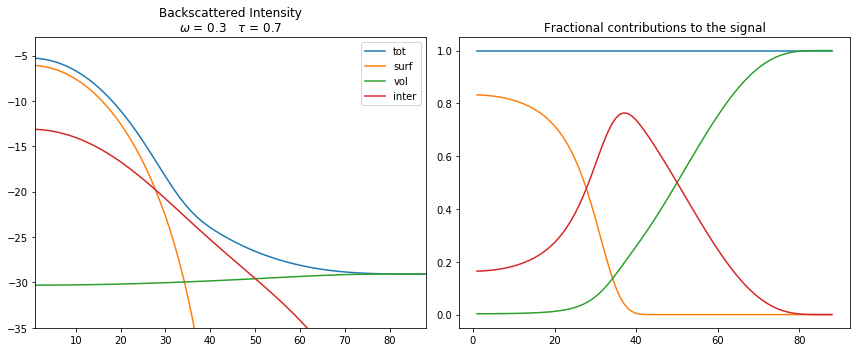

In [13]:
# plot backscatter as function of incidence angle

f, [ax, ax2] = plt.subplots(1,2, figsize=(12,5))
ax.set_title('Backscattered Intensity'+'\n$\\omega$ = ' + str(R.V.omega) + '$ \quad \\tau$ = ' + str(R.V.tau))
ax2.set_title('Fractional contributions to the signal')

resdb = 10.*np.log10(res[res!=0])
resdb.plot(ax=ax)
ax.legend()
ax2.plot(res.div(res.tot, axis=0))

_ = ax.set_ylim(-35,-3)
ax.set_ylim()
f.tight_layout()

**!! Difference to results in Quast & Wagner (2016) !!**

Due to an error in the definitions of the code that has been used to generate the 
example-plots of the paper, the results for example 2 do not coincide with the results 
presented above. (Due to the symmetry-properties of the Rayleigh phase-function this has no effects 
on the results of example 1)

The error was located in the fn-coefficient generation algorithm, where a wrong 
assignment of the incidence-angle of the scattering phase-function has been used.
$\hat{p}({\color{red}{\theta_0}},\theta_{ex},\phi_0,\phi_{ex}) \quad \leftrightarrow \quad \hat{p}({\color{green}{\pi-\theta_0}},\theta_{ex},\phi_0,\phi_{ex})$

The error can be reproduced by changing the generalized scattering parameter of the volume-scattering
phase-function during the evaluation of the fn-coefficients and reverting the changes afterwards, i.e.:

    V.a = [1.,1.,1.]
    R = RT1(I0, 0., 0., 0., 0., RV=V, SRF=SRF, geometry='mono')  
    fn = R.fn  # store coefficients for faster iteration 
    V.a = [-1.,1.,1.]

This is equivalent to a $\pi$-shift of $\theta_0$ in the scattering angle since
for $a_1 = a_2 = 1$ we have:

$\cos(\Theta) =   a_0 * \cos(\theta_0) \cos(\theta_{ex})         + \sin(\theta_0) \sin(\theta_{ex}) \cos(\phi_0 - \phi_{ex})$
$\phantom{\cos(\Theta)} = - a_0 * \cos(\pi - \theta_0) \cos(\theta_{ex}) + \underbrace{\sin(\pi-\theta_0)}_{\sin(\theta_0)} \sin(\theta_{ex}) \cos(\phi_0 - \phi_{ex})$


Uncommenting the following lines will thus reproduce the erroneous plot of example 2 in the paper:


In [15]:
#V.a = [1.,1.,1.]
#R = RT1(I0, 0., 0., 0., 0., V=V, SRF=SRF, geometry='mono')  
#fn = R.fn  # store coefficients for faster iteration 
#V.a = [-1.,1.,1.]

#R = RT1(I0, t_0, t_ex, p_0, p_ex, V=V, SRF=SRF, fn_input=fn, geometry='mono')
#res2 = pd.DataFrame(dict(zip(('tot','surf','vol','inter'), R.calc())), index=inc)


#f, [ax, ax2] = plt.subplots(1,2, figsize=(12,5))
#ax.set_title('Backscattered Intensity'+'\n$\\omega$ = ' + str(R.V.omega) + '$ \quad \\tau$ = ' + str(R.V.tau))
#ax2.set_title('Fractional contributions to the signal')

#resdb = 10.*np.log10(res2[res2!=0])
#resdb.plot(ax=ax)
#ax.legend()
#ax2.plot(res2.div(res2.tot, axis=0))

#_ = ax.set_ylim(-35,-3)
#ax.set_ylim()
#f.tight_layout()